## Load Data

In [1]:
import pandas as pd

data = pd.read_csv('SambnisImp.csv')
data_full = data[["warstds", "ager", "agexp", "anoc", "army85", "autch98", "auto4",
        "autonomy", "avgnabo", "centpol3", "coldwar", "decade1", "decade2",
        "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel",
        "durable", "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590",
        "expgdp", "exrec", "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2",
        "geo34", "geo57", "geo69", "geo8", "illiteracy", "incumb", "infant",
        "inst", "inst3", "life", "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper",
        "mirps0", "mirps1", "mirps2", "mirps3", "nat_war", "ncontig",
        "nmgdp", "nmdp4_alt", "numlang", "nwstate", "oil", "p4mchg",
        "parcomp", "parreg", "part", "partfree", "plural", "plurrel",
        "pol4", "pol4m", "pol4sq", "polch98", "polcomp", "popdense",
        "presi", "pri", "proxregc", "ptime", "reg", "regd4_alt", "relfrac", "seceduc",
        "second", "semipol3", "sip2", "sxpnew", "sxpsq", "tnatwar", "trade",
        "warhist", "xconst"]]

In [2]:
X = data_full.drop('warstds', axis=1).values
y = data_full['warstds'].values

## Generate data for 10-fold CV

In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [4]:
K = 10

cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

## Train and Eval

In [5]:
import numpy as np
from scipy import interp
from tqdm import tqdm

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [7]:
def train_and_eval(classifier, cv):
    
    y_true = np.array([])
    y_pred = np.array([])

    for i, (train, test) in enumerate(cv.split(X, y)):
        probs = classifier.fit(X[train], y[train]).predict_proba(X[test])
        y_true = np.concatenate((y_true, y[test]))
        y_pred = np.concatenate((y_pred, probs[:, 1]))

    return roc_auc_score(y_true, y_pred)

In [8]:
# Mulchinski used Rs default of 1000 estimators but probably overkill
n_estimators = list(range(5, 105, 5))

In [9]:
auc_scores = []

for n in tqdm(n_estimators):
    clf = RandomForestClassifier(n_estimators=n)
    auc_scores.append(train_and_eval(clf, cv))
    
print('DONE')

100%|██████████| 20/20 [02:07<00:00, 10.62s/it]

DONE


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 0, 'Number of Trees')

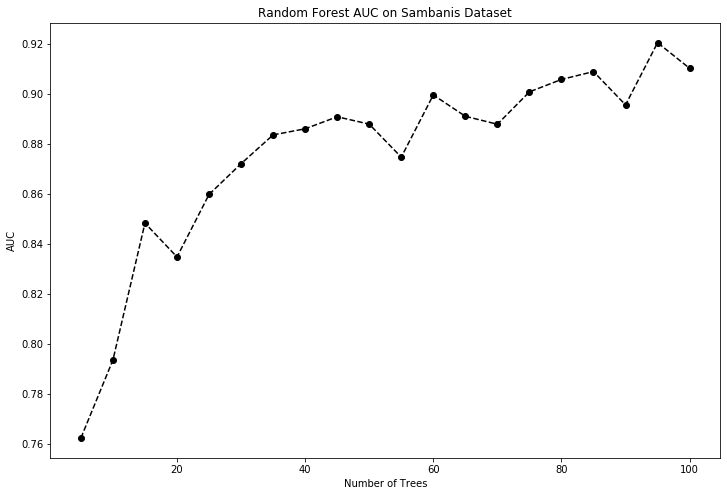

In [11]:
plt.figure(figsize=(12,8))
plt.errorbar(n_estimators, auc_scores, marker="o", linestyle="--", color="black")
plt.title('Random Forest AUC on Sambanis Dataset');
plt.ylabel('AUC')
plt.xlabel('Number of Trees')

## Adaboost Classifier  - Wang

In [13]:
# from Wang (2018)
n_trees = 50
max_tree_depth = 2

In [14]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [16]:
clf_wang_auc_samples = []

for n in n_estimators:
    clf_wang = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=max_tree_depth),
                                  n_estimators=n,
                                  learning_rate=0.1)
    
    clf_wang_auc_samples.append(train_and_eval(clf_wang, cv))
    print(clf_wang_auc_samples[-1], f"n_estimators: {n}")

0.8926206209253005 n_estimators: 5
0.9215540560443013 n_estimators: 10
0.9175241536407195 n_estimators: 15
0.9134764551095751 n_estimators: 20
0.9182218845730893 n_estimators: 25
0.9142668486371849 n_estimators: 30
0.9045869825622497 n_estimators: 35
0.9008682055612285 n_estimators: 40
0.9004926459036997 n_estimators: 45
0.9025336776372634 n_estimators: 50
0.8958766986096929 n_estimators: 55
0.8973261625166916 n_estimators: 60
0.8963909453302962 n_estimators: 65
0.8959982032047757 n_estimators: 70
0.8955330492498625 n_estimators: 75
0.8914939419527138 n_estimators: 80
0.8941265415128428 n_estimators: 85
0.8954827291650302 n_estimators: 90
0.8949353448275862 n_estimators: 95
0.8976673572382373 n_estimators: 100


Text(0.5, 0, 'Number of Estimators')

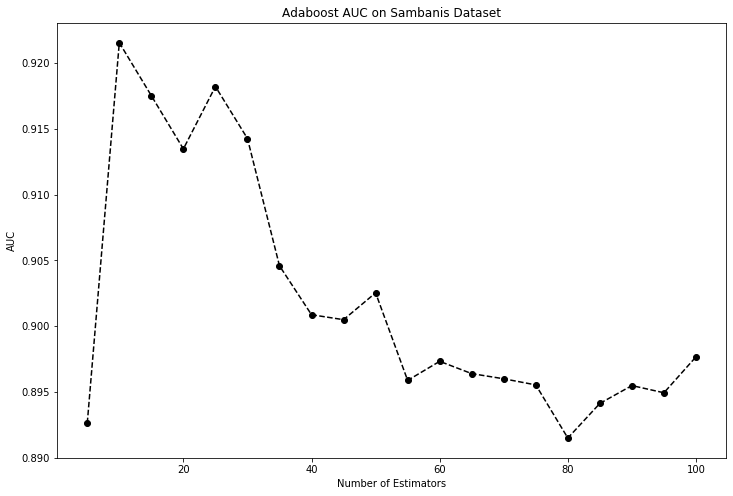

In [20]:
plt.figure(figsize=(12,8))
plt.plot(n_estimators, clf_wang_auc_samples, marker="o", linestyle="--", color="black")
plt.title('Adaboost AUC on Sambanis Dataset');
plt.ylabel('AUC')
plt.xlabel('Number of Estimators')